In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.display import clear_output
import copy
import numpy as np
import glob
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image

In [2]:
import sys
sys.path.append("../pyfiles/")
from util import MinMax, weights_init, cuda2numpy, do_test_VAE, plot_confusion_matrix, image_from_output, transform_original, image_from_numpy
from dataset import transform, Dataset_MNIST
from model import VAE

# Preparation

In [3]:
root = "../dataset/MNIST/"
classes = tuple(range(10))

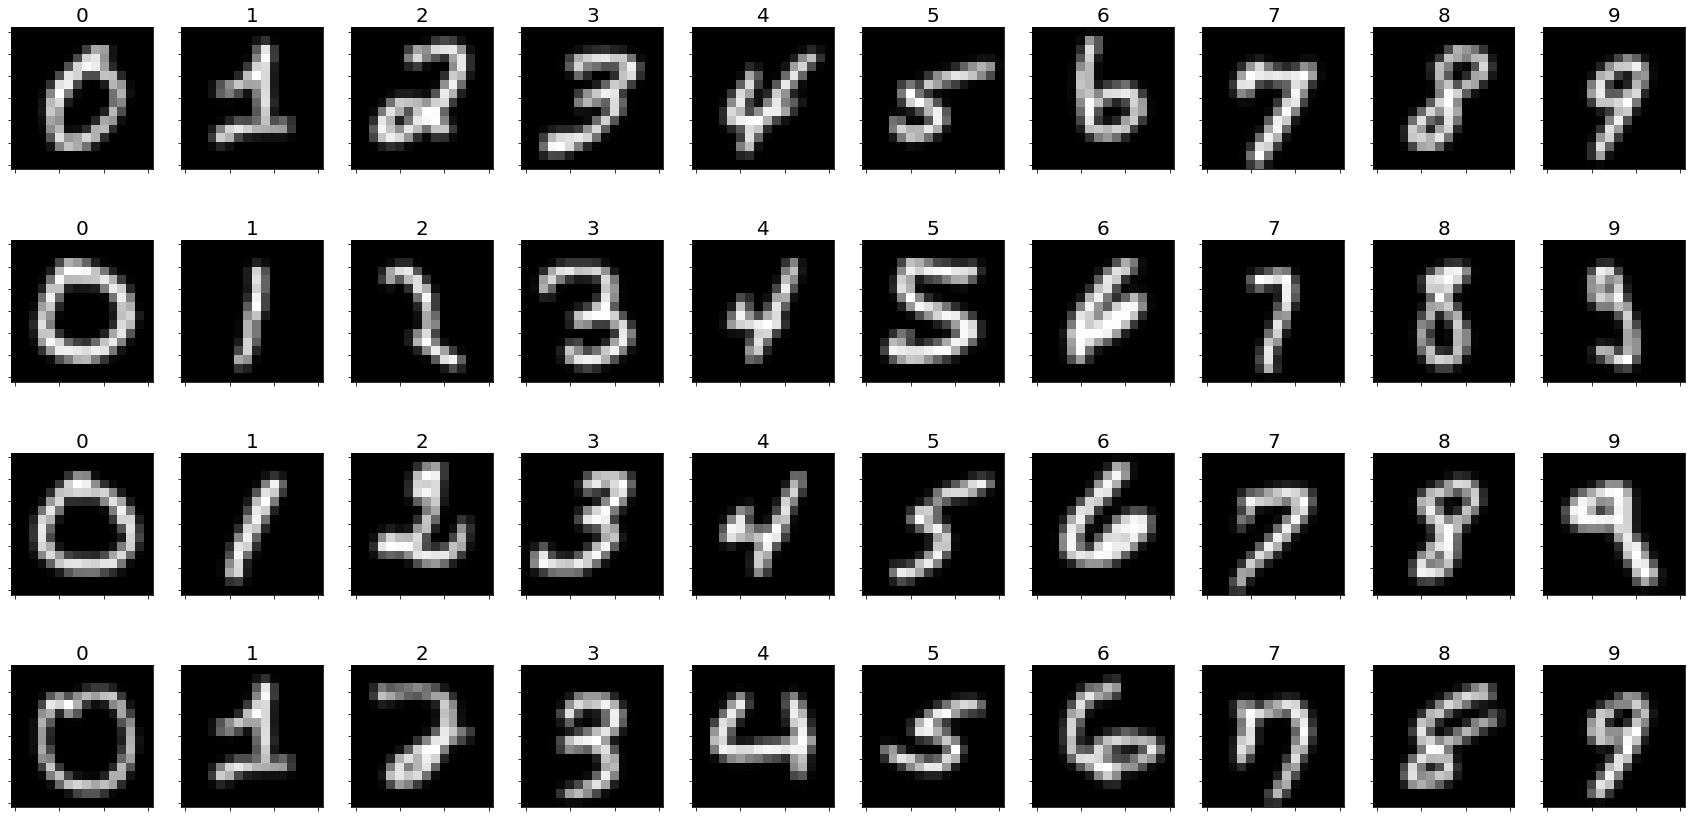

In [4]:
dataset = Dataset_MNIST(root, classes, "train", transform["train"])
display_num = 4
each_num = int(len(dataset)/len(classes))
fig = plt.figure(figsize=(30, 15))
for i in range(display_num):
    for cl in classes:
        ax = fig.add_subplot(display_num, len(classes), len(classes)*i+cl+1)
        index = np.random.randint(0,each_num)+cl*each_num
        x, label = dataset[index]
        ax.imshow(image_from_output(x)[0])
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_title(f"{cl}", fontsize=20)

## Models

In [5]:
epoch_num = 501
lr = 0.001
save_parameter = True # do you wanna save parameters ?
test_interval = 3 # the interval among validation check
device = "cpu"
device

'cpu'

In [6]:
nch = 16
n_layers = 3
z_dim = 3

In [7]:
net = VAE(z_dim=z_dim, nch_input=1, nch=nch, device=device, image_shape=(16, 16), n_layers=n_layers).to(device)
net.apply(weights_init)
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

---
データセットを呼び出しましょう。`Dataloader`とはデータをバッチサイズにまとめてくれて、必要であればシャッフルしてくれます。

---
This is the preparation of the dataset. `Dataloader` combines the individual data to make batch-sized data and it shuffles them if you want.

---

In [8]:
# ----- adjustable parameters ----- #
train_batch = 32
val_batch = 32
each_datanum = 300
numbers = (1, 7, 8, 3)
# --------------------------------- #

dataset = Dataset_MNIST(root, numbers, "train", transform["train"], each_datanum=each_datanum)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=train_batch, shuffle=True)
valset = Dataset_MNIST(root, numbers, "val", transform["test"], each_datanum=each_datanum)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=val_batch, shuffle=False)
len(dataset), len(valset)

(840, 180)

# Classification
---
では、訓練してみましょう。
このセルにはエポックごとのロスと正解率を出すようにしてます。
そして、検証用データにおいての一番いいエポックを記憶するようにしているので、後に呼び出してみましょう。

---
Let's train your model.
The notebook shows you the losses and the accuracies in every epoch.
What's more, it'll store the best epoch for the validation dataset, so you can call it when the training is finished.

---

In [10]:
test_interval = 3
fixed_image = dataset[100][0].unsqueeze(0)

In [11]:
train = False

if train:
    losses_epoch = []
    losses_epoch_test = []
    best_epoch = 0
    best_loss = np.inf
    for epoch in range(epoch_num):
        losses = []
        for itr, data in enumerate(dataloader):
            net.train()
            x = data[0].to(device)
            label = data[1].to(device)
            optimizer.zero_grad()
            _, _, loss = net(x, True)
            loss.backward()
            optimizer.step()

            loss = loss.to("cpu").detach().numpy()
            label = label.to("cpu").detach().numpy()
            losses.append(loss)
        losses_epoch.append(np.mean(np.array(losses)))
        scheduler.step()
        if epoch%test_interval==0:
            labels, inputs, outputs, loss_test, latents = do_test_VAE(net, valloader, device, "eval")
            losses_epoch_test.append(loss_test)
            if best_loss > loss_test:
                best_loss = loss_test
                best_epoch = epoch

        clear_output(wait=True)
        print(epoch)
        print(f"test loss in {epoch//test_interval*test_interval} : {loss_test}")
        print(f"best loss is   : {best_loss} in epoch{best_epoch}")
        if save_parameter:
            if epoch%test_interval==0:
                torch.save(net.state_dict(), 
                           f"../instant_parameters/VAE_MNIST_ndim{z_dim}_nch{nch}_lr{lr}_epoch{epoch}.pth")

        width = 3
        val_num = 2
        height = 1 + val_num

        fig = plt.figure(figsize=(5*width,5*height))
        ax = fig.add_subplot(height,width,1)
        ax.plot(losses_epoch, label="train")
        ax.plot(np.arange(epoch//test_interval+1)*test_interval, losses_epoch_test, label="val")
        ax.legend()
        ax.set_title('loss')
        net.eval()
        fixed_output, _ = net(fixed_image)

        ax = fig.add_subplot(height,width,2)
        M = image_from_output(fixed_image)[0]
        ax.imshow(M)
        ax.set_title("train input")
        ax = fig.add_subplot(height,width,3)
        M = image_from_output(fixed_output)[0]
        ax.imshow(M)
        ax.set_title("train output")
        for i in range(val_num):
            ax = fig.add_subplot(height,width,3+i*3+2)
            idx = len(valset)//val_num*i
            M = image_from_output(torch.tensor(inputs[idx:idx+1]))[0]
            ax.imshow(M)
            ax.set_title(f"val input:{i}")
            ax = fig.add_subplot(height,width,3+i*3+3)
            M = image_from_output(torch.tensor(outputs[idx:idx+1]))[0]
            ax.imshow(M)
            ax.set_title(f"val output:{i}")
        plt.show()

## Result
---
訓練完了するためにはGPUがないと時間がかかってしまうので、訓練しておきました。
以下のコードで呼び出してみましょう。

---
Since this requires GPU to train quickly, I've stored the best parameters. So let's call it with the code below.

---

In [12]:
load_epoch = 462
dir = "../instant_parameters/"
dir = "../data/parameters/E"

load_parameter = True
if load_parameter:
    model_path = f"{dir}VAE_MNIST_ndim{z_dim}_nch{nch}_lr{lr}_epoch{load_epoch}.pth"
    model = torch.load(model_path)
    net.load_state_dict(model)

---
テストデータセットを呼び出しましょう。もちろん訓練データセットと検証データセットとは異なります。

---
This is the test dataset. Of course, this is separated from the training and the validation dataset.

---

In [13]:
# ----- adjustable parameters ----- #
test_batch = 512
# --------------------------------- #

testset = Dataset_MNIST(root, numbers, "val", transform["test"], each_datanum=each_datanum)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=test_batch, shuffle=False)
len(testset)

180

In [14]:
labels, inputs, outputs, _, latents = do_test_VAE(net, testloader, device, "eval")

## Reconstructed Images

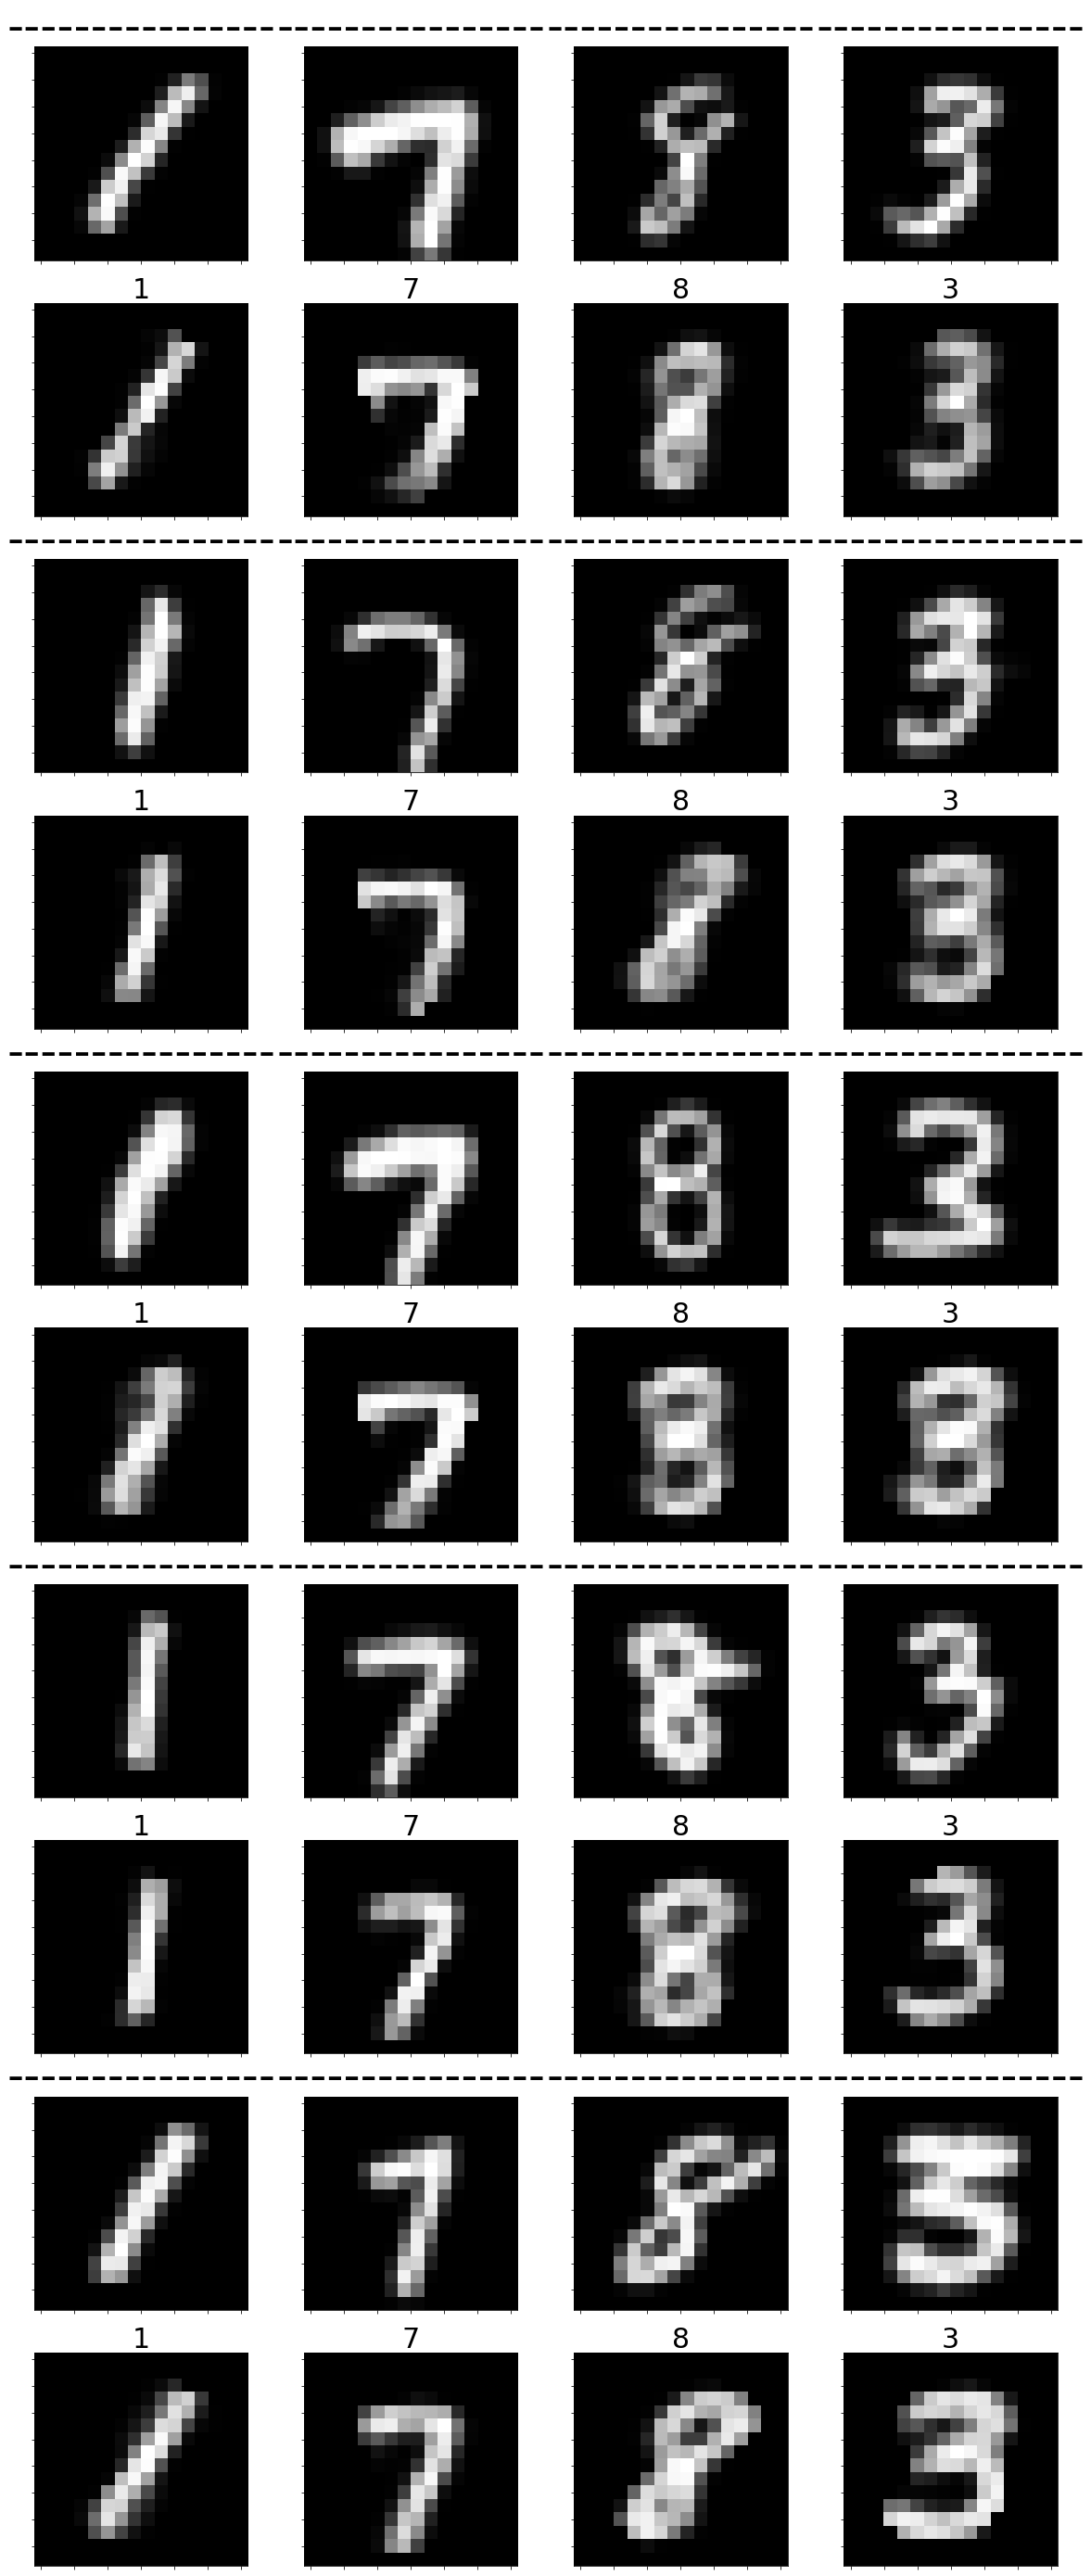

In [15]:
display_num = 5

height = display_num * 2
width = len(numbers)
fig = plt.figure(figsize=(5*width, 5*height), facecolor="w")

for j in range(len(numbers)):
    x = inputs[labels==numbers[j]]
    y = outputs[labels==numbers[j]]
    for i in range(display_num):
        ax = fig.add_subplot(height, width, i*2*width+j+1)
        M = image_from_numpy(x[i:i+1])[0]
        ax.imshow(M)
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_title("----------------", fontsize=50)
        
        ax = fig.add_subplot(height, width, (i*2+1)*width+j+1)
        M = image_from_numpy(np.expand_dims(y[i:i+1], 0))[0]
        ax.imshow(M)
        ax.set_title(numbers[j], fontsize=30)
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

## Latent codes

### Check the distribution

In [16]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [17]:
plotly.offline.init_notebook_mode(connected=True)

#### 1d

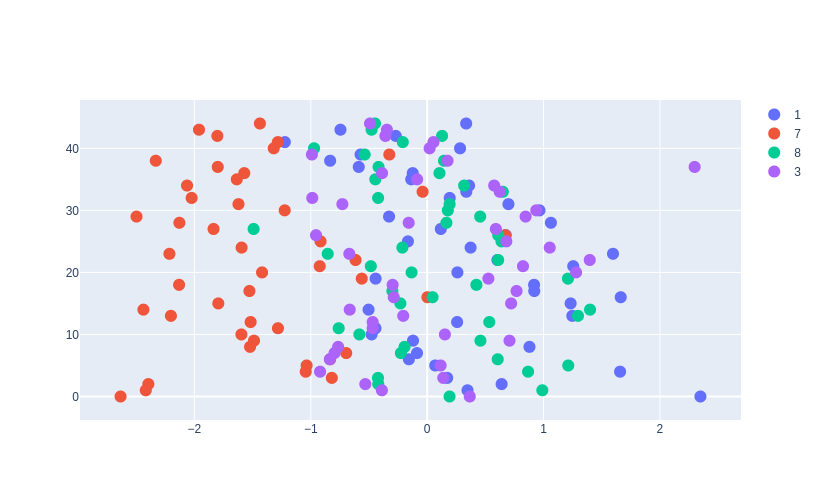

In [18]:
target_dims = [0]

trace = []
for i in range(len(numbers)):
    m = latents[labels==numbers[i]]
    _x = m[:, target_dims[0]] 
    trace.append(go.Scatter(x=_x, mode="markers", name=f"{numbers[i]}", 
                              marker = dict(size=12)))
layout = go.Layout(width=700, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

#### 2d

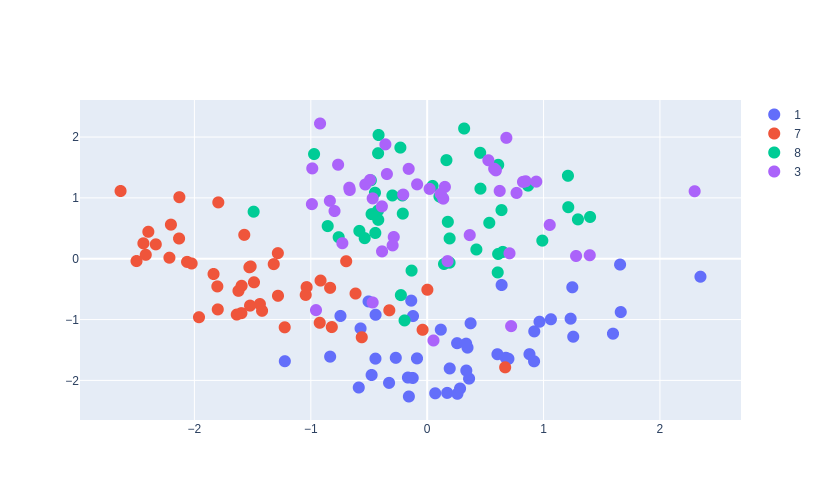

In [19]:
target_dims = [0, 1]

trace = []
for i in range(len(numbers)):
    m = latents[labels==numbers[i]]
    _x = m[:, target_dims[0]] 
    _y = m[:, target_dims[1]]
    trace.append(go.Scatter(x=_x, y=_y, mode="markers", name=f"{numbers[i]}", 
                              marker = dict(size=12)))
layout = go.Layout(width=700, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

#### 3d

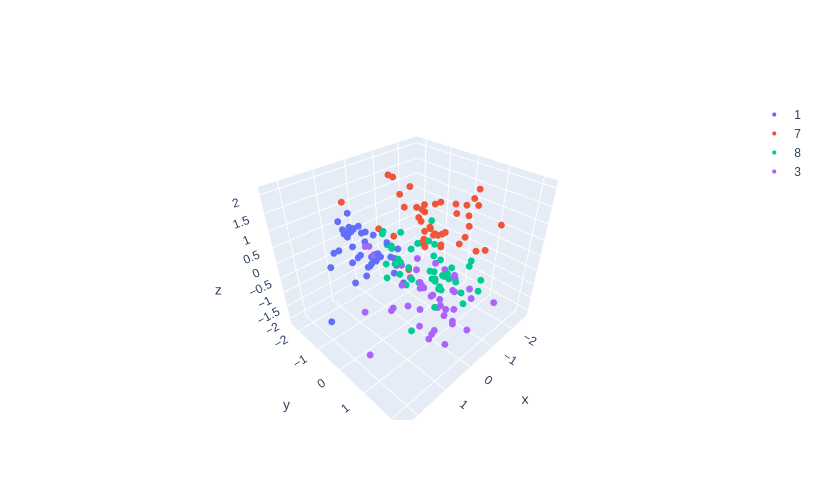

In [20]:
target_dims = [0, 1, 2]

trace = []
for i in range(len(numbers)):
    m = latents[labels==numbers[i]]
    _x = m[:, target_dims[0]] 
    _y = m[:, target_dims[1]]
    _z = m[:, target_dims[2]]
    trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"{numbers[i]}", 
                              marker = dict(size=4)))
layout = go.Layout(width=700, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

### images alinghed in 2D

In [21]:
target_dims = [0, 1] 
x_num = 8
y_num = 8

target_dims = np.array(target_dims)
fixed_dims = np.sort(np.array(list(set(list(range(z_dim)))-set(list(target_dims)))))
fixed_mean = np.mean(latents[:, fixed_dims], axis=0)

In [22]:
min_ = np.min(latents[:, target_dims], axis=0)
max_ = np.max(latents[:, target_dims], axis=0)

In [23]:
xax = np.linspace(min_[0], max_[0], num=x_num).reshape(1, -1)
yax = np.linspace(min_[1], max_[1], num=y_num).reshape(-1, 1)

In [24]:
target_latents = np.ones((x_num*y_num, z_dim))

In [25]:
target_latents[:, target_dims[0]] = np.tile(xax, reps=(x_num, 1)).reshape(-1)
target_latents[:, target_dims[1]] = np.tile(yax, reps=(1, y_num)).reshape(-1)
for i in range(len(fixed_dims)):
    target_latents[:, fixed_dims[i]] = target_latents[:, fixed_dims[i]] * fixed_mean[i]

In [26]:
z = torch.tensor(target_latents, dtype=net.state_dict()["encoder.1.weight"].dtype)
y = net._decoder(z)
images = image_from_output(y.unsqueeze(1))

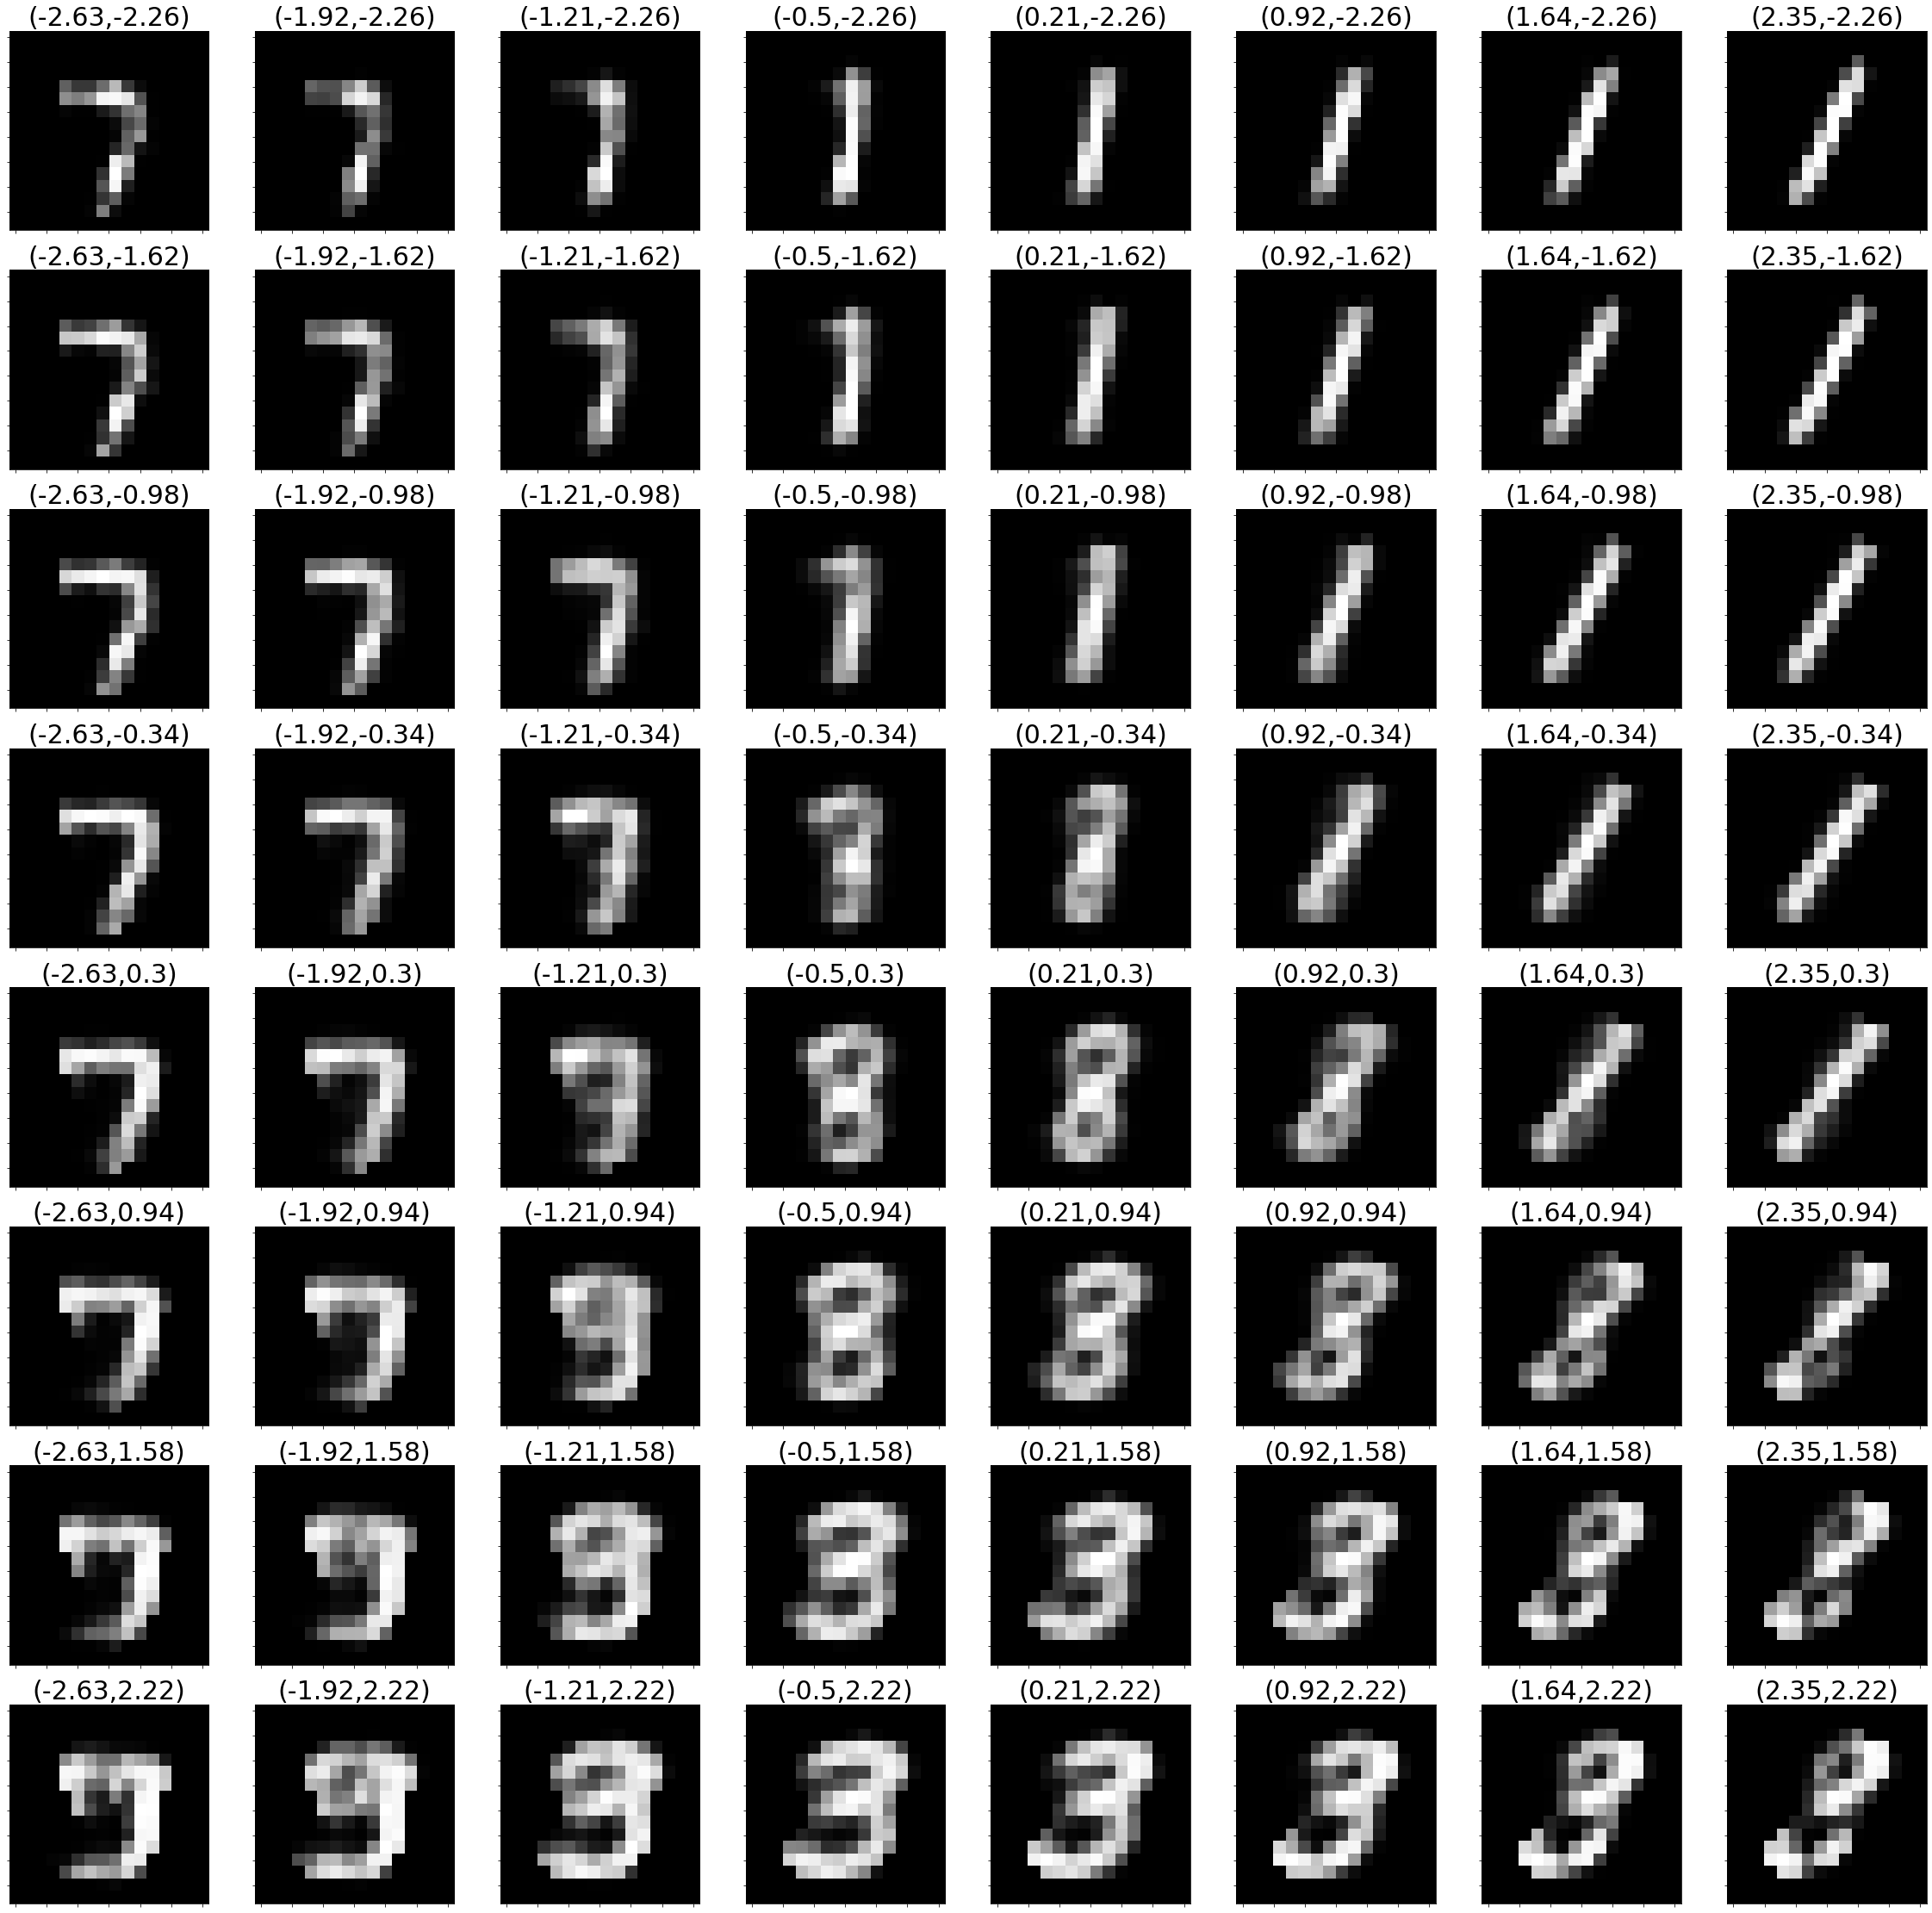

In [28]:
height = x_num
width = y_num
fig = plt.figure(figsize=(5*width, 5*height), facecolor="w")

for j in range(height*width):
    ax = fig.add_subplot(height, width, j+1)
    M = images[j]
    ax.imshow(M)
    x_ = str(np.round(target_latents[:,target_dims[0]][j], 2))
    y_ = str(np.round(target_latents[:,target_dims[1]][j], 2))
    ax.set_title(f"({x_},{y_})", fontsize=30)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)